# 2. Energy prediction modeling
---

## Introduction

In this jupyter notebook, we will be performing time series analysis on the Global Horizontal Irradiation data that was generated from our original dataset. 

### Contents
[Loading Data Generated from EDA](#Loading-Data-Generated-from-EDA)

[EDA](#EDA)

[Preprocessing data](#Preprocessing-data)

[SARIMA Model](#SARIMA-Model)

[Facebook Prophet](#Facebook-Prophet)

[Model Evaluation](#Model-Evaluation)

[Conclusion](#Conclusion)

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from datetime import datetime


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm_notebook

from itertools import product

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')


## Loading Data Generated from EDA

In [2]:
df_daily = pd.read_csv('daily_energy_table.csv', index_col=0)
df_daily.head()

date    GHI
0  1998-01-01  552.0
1  1998-01-02  126.5
2  1998-01-03  442.5
3  1998-01-04  371.5
4  1998-01-05  543.5

In [3]:
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.set_index('date')
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8395 entries, 1998-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GHI     8395 non-null   float64
dtypes: float64(1)
memory usage: 131.2 KB


Let's plot if to see what the daily radiation energy is like

## EDA

In [4]:
fig = px.line(df_daily, x=df_daily.index, y=df_daily.columns,)


fig.update_layout(
    yaxis_title="Daily solar irradiation 1998-2020 (wh/m^2)", 
    title="Daily solar irradiation 1998-2020 in Calgary"
)

fig.update_xaxes(rangeslider_visible=True)

fig.show()

We can clearly see that the daily solar irradiation level is flowing in a strong pattern, which is no surprise as we got a lot of sunlight in June-August, and not much much sunlight.

Since we are more interested in using the energy data to do long term, yearly predictions, it will make more sense to generate a monthly energy dataset based on the daily data we have, at the same time, as an industrial practice, we will transform out data with a unit wh/$m^2$ to kWh/$m^2$.

In [6]:
df_monthly = df_daily.resample("MS").sum()/1000

df_monthly.head()

GHI
date                
1998-01-01   24.0200
1998-02-01   58.3380
1998-03-01   79.4195
1998-04-01  138.0580
1998-05-01  184.4910

In [96]:
fig = px.line(df_monthly, x=df_monthly.index, y='GHI',)
fig.update_layout(
    yaxis_title="Monthly GHI (kWh/m^2)", 
    xaxis_title="Date",
    title="Monthly Solar Radiation recieved in Calgary over 1998-2000"
)

#fig.update_xaxes(rangeslider_visible=True)
fig.show()

Now, let's take a look at how much GHI deviated from the annual mean per month.

We do see that for some years, there is a lower GHI received in June than in May, after cross-checking with the weather data on https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=50430, this is mostly caused by having heavier and more rain falls, which information is not contained in our dataset. I would assume having perception data would be helpful for this project to understand the pattern. It could also be helpful in power prediction.

We will also check how the monthly mean differs from the annual mean.

In [97]:
# this block of code is similar to the class notebook

monthly_mean = df_monthly.groupby(df_monthly.index.month_name()).mean()

monthly_mean_diff = (monthly_mean - monthly_mean.mean())

month_names = pd.date_range(start='1998-01', freq='M', periods=12).month_name()

monthly_mean_diff = monthly_mean_diff.loc[month_names, ]

monthly_mean_diff.T

January   February     March      April        May       June  \
GHI -74.988534 -52.945252 -7.151426  33.406118  65.578357  71.562857   

         July     August  September    October   November   December  
GHI  92.36477  56.016574   3.770792 -36.788143 -70.202904 -80.623208

In [101]:
fig = px.bar(monthly_mean_diff)

fig.update_layout(
    yaxis_title="Global Horizontal Radiation (kWh/m^2)", 
    xaxis_title="Month",
    title="Monthly Deviation from Annual Mean ",
    showlegend=False,
)
fig.show()

This pattern correlates to the data we have. Now we can go ahead to decompose our data.

## Preprocessing data 

First, let's decompose the data.

In [11]:
stl = STL(df_monthly)
result=stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid

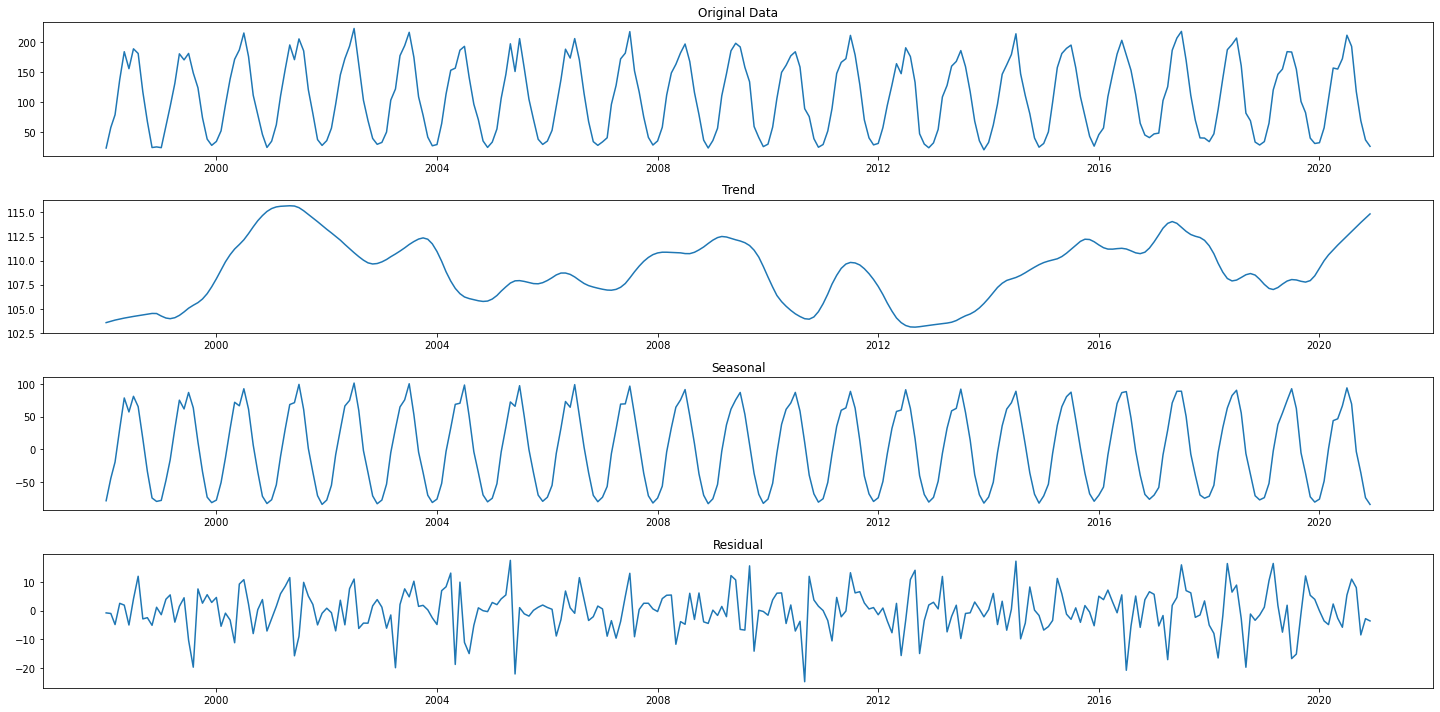

In [12]:
plt.figure(figsize=(20, 10))

plt.subplot(4, 1, 1)
plt.plot(df_monthly['GHI'])
plt.title('Original Data')

plt.subplot(4, 1, 2)
plt.plot(trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

A part from the dip of GHI happened in June for some years, there are a few other findings from the decomposition plot:

- There is no clear trend of the solar irradiation over the years, which could be caused be a combination of the dolar cycle and climate change.
- The seasonal plot is what we are expecting, it matches what we observed in the bar plot.
- There is no obvious pattern in residual.

Second, lets split our data into a train and test set, we will set aside the data from the last 24 month as our test set.

In [19]:
train = df_monthly.loc[df_monthly.index < '2019-01-01']
test = df_monthly.loc[df_monthly.index >= '2019-01-01']

In [20]:
train # double check the time range of train set

GHI
date                
1998-01-01   24.0200
1998-02-01   58.3380
1998-03-01   79.4195
1998-04-01  138.0580
1998-05-01  184.4910
...              ...
2018-08-01  161.1015
2018-09-01   82.1670
2018-10-01   69.5020
2018-11-01   34.0065
2018-12-01   29.0620

[252 rows x 1 columns]

Third, let's take a look at the ACF and PACF plots of our train set.

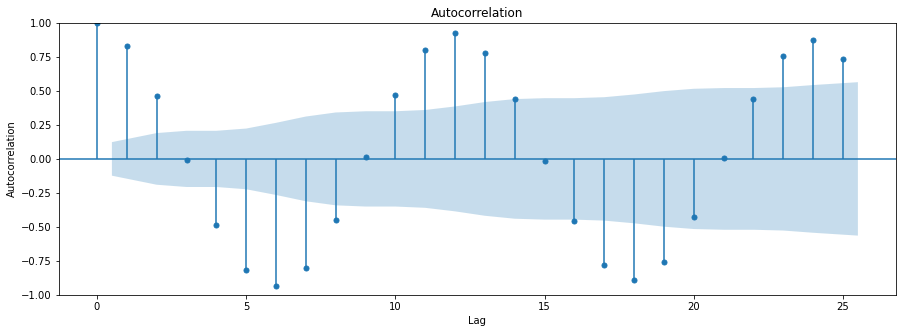

In [21]:
plt.rcParams['figure.figsize'] = [15, 5]
plot_acf(train)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

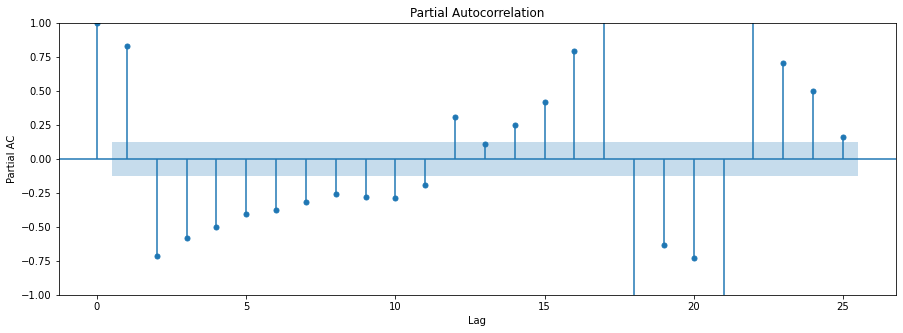

In [22]:
plot_pacf(train)
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

This data set is clearly not stationary as we can see a strong seasonality of every 12 months, therefore, we will be doing a seasonal differencing at with lag = 12.

In [24]:
train['GHI_tr'] = train['GHI'].diff(12)
train.head(20)

GHI   GHI_tr
date                         
1998-01-01   24.0200      NaN
1998-02-01   58.3380      NaN
1998-03-01   79.4195      NaN
1998-04-01  138.0580      NaN
1998-05-01  184.4910      NaN
1998-06-01  156.2385      NaN
1998-07-01  189.3320      NaN
1998-08-01  181.5575      NaN
1998-09-01  117.5135      NaN
1998-10-01   68.1835      NaN
1998-11-01   24.8355      NaN
1998-12-01   25.8905      NaN
1999-01-01   24.6195   0.5995
1999-02-01   60.2775   1.9395
1999-03-01   93.2600  13.8405
1999-04-01  131.7955  -6.2625
1999-05-01  180.9580  -3.5330
1999-06-01  170.8940  14.6555
1999-07-01  181.6080  -7.7240
1999-08-01  149.0685 -32.4890

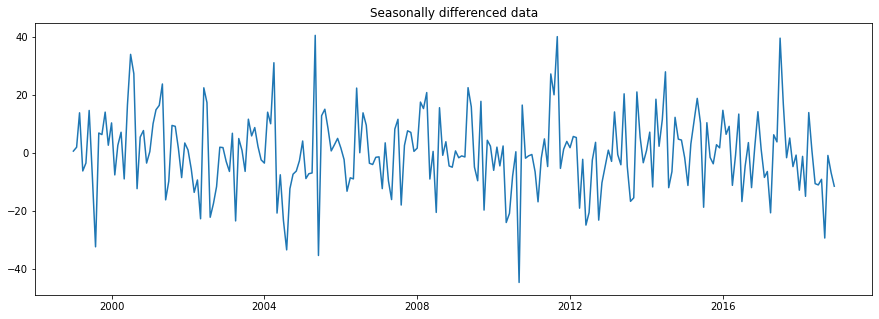

In [27]:
plt.plot(train['GHI_tr'])
plt.title('Seasonally differenced data')
plt.show()

By looking at the plot of the seasonally differenced data, it does not seem to show trend or seasonality, however, we will confirm that by using the Augmented Dickey-Fuller test to test whether there is a unit root in the seasonally differenced data.

For the  Augmented Dickey-Fuller test, our Null Hypothesis and Alternative Hypothesis are:


- $H_0$: the time series has a unit root, data is not stationary.


- $H_1$: the time series has no unit root, it does not have time dependent structure

In [28]:
result = adfuller(train['GHI_tr'][12:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.977038
p-value: 0.000025
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


Running the test, we see that the test statistic value of -4.48 which is less than the value of -3.46 at 1%. We also got a p-value less than 0.05 which suggests that we can reject the null hypothesis that says there is a unit root in this time series.

Now, let's take a look at the ACF and PACF of the seasonally differenced data.

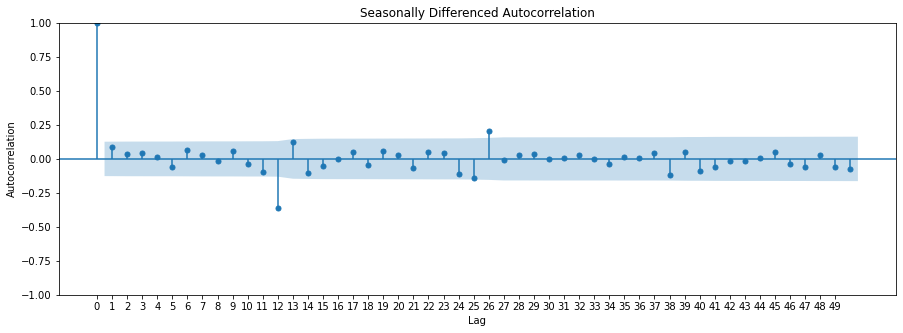

In [210]:
plot_acf(train['GHI_tr'][12:], lags=50)
plt.xticks(list(range(0, 50)))
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Seasonally Differenced Autocorrelation')
plt.show()

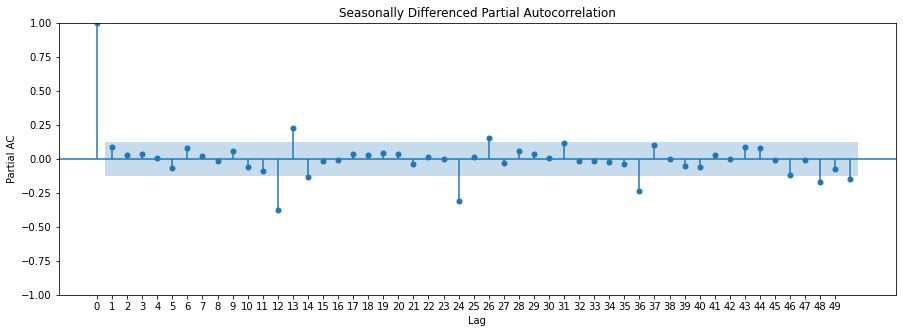

In [211]:
plot_pacf(train['GHI_tr'][12:], lags=50)
plt.xticks(list(range(0, 50)))
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Seasonally Differenced Partial Autocorrelation')
plt.show()

From the plots above, we find:

- We don't observe a significant lag for the first few lags in both ACF and PCF plots. 
- We can still see some seasonality in ACF and PACF.

In my opinion, it is not our best option to try to use any model to fit our seasonally differenced data as there is no significant lags in both ACF and PACF till the 12th lag, which is caused by remaining seasonality. A SARIMA model would be more fit in this case. 

By looking at the plots, for the seasonal part, we see 1 significant 12th lag on ACF, we see significant lags on the 12th, 24th, 36th, and 48th on PACF. We will start with a simple model, because we only have one significant seasonal lag on ACF, we will use the MA1 model for the seasonal part. Therefore, P will be set at 0, Q will be set at 1, since we did one seasonal differencing, D will be 1, s will be 12.

## SARIMA Model

### 1. Fitting Simplest Model 

In [193]:
model = SARIMAX(train['GHI'], order=(0,0,0), seasonal_order=(0,1,1,12), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:                        GHI   No. Observations:                  252
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -918.963
Date:                    Sun, 03 Apr 2022   AIC                           1841.926
Time:                            00:55:35   BIC                           1848.888
Sample:                        01-01-1998   HQIC                          1844.731
                             - 12-01-2018                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9581      0.106     -9.018      0.000      -1.166      -0.750
sigma2       110.3976     12.177      9.066      0.000      86.531     134.264
Ljung-Box (L1) (Q): 

We will use RMSE in combination with $R^2$ value to evaluate our model.

In [194]:
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

print(f"Train R^2: {r2_score(train[12:]['GHI'], predictions[train.index][12:])}")
print(f"Test R^2: {r2_score(test, predictions[test.index])}")

Train R^2: 0.9666757405559939
Test R^2: 0.9590588715952859


In [171]:
print('Root Mean Squared Error_train:', np.sqrt(mean_squared_error(train[12:]['GHI'], predictions[train.index][12:])))
print('Root Mean Squared Error_test:', np.sqrt(mean_squared_error(test, predictions[test.index])))

Root Mean Squared Error_train: 11.164870231553088
Root Mean Squared Error_test: 11.985503078057524


We will create a table to track out model's performance.

In [205]:
tracking = pd.DataFrame(index = ['Train_R^2', 'Test_R^2', 'Train_RMSE', 'Test_RMSE'])
tracking['(000)(01112)'] = [0.967, 0.959, 11.16, 11.99]
tracking

(000)(01112)
Train_R^2          0.967
Test_R^2           0.959
Train_RMSE        11.160
Test_RMSE         11.990

In [130]:
test.mean()

GHI    110.162479
dtype: float64

The result is not too bad, consider the mean is 110.17. We will further optimize the hyperparameters. Base on the seasonal ACF and PACF, we will try p with (0, 1), q with (0, 1), P with (0, 1, 2, 3, 4) and Q with (0, 1, 2). We will use RMSE on the test set to determine the best combination of the hyperparameters.

### 2. Hyperparameter Tuning

We will create a 'grid search' function to try out different combinations of p, q, P, Q, and trend, We will pick the best model by the smallest RMSE on the test set.

In [33]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding RMSE and trend type
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        endog - the observed variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        for t in ['n','c','t','ct']:  # loop through different types of trend
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), trend = t, simple_differencing=False).fit(disp=False)
        
            
            pred = model.predict(start = 252, end=275)
            rmse = np.sqrt(mean_squared_error(test, pred))
        
        
            results.append([param, rmse, t])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'RMSE', 'Trend']
    
    #Sort in ascending order, lower RSME is better
    result_df = result_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
    
    return result_df
    
    
    

In [34]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 5, 1)
D = 1
Q = range(0, 3, 1)
s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[:5])

60
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 1, 0), (0, 0, 1, 1)]


In [35]:
result_df = optimize_SARIMA(train['GHI'], parameters_list, 0, 1, 12)
result_df


  0%|          | 0/60 [00:00<?, ?it/s]

(p,q)x(P,Q)       RMSE Trend
0    (0, 0, 2, 2)  11.695933     n
1    (0, 0, 4, 1)  11.742341     n
2    (0, 0, 4, 1)  11.751539     t
3    (0, 0, 4, 1)  11.759216     c
4    (1, 0, 4, 1)  11.775286     t
..            ...        ...   ...
235  (1, 1, 0, 0)  19.049201     t
236  (1, 0, 0, 0)  19.274850    ct
237  (0, 0, 0, 0)  19.280845    ct
238  (0, 1, 0, 0)  19.291783    ct
239  (1, 1, 0, 0)  19.413666    ct

[240 rows x 3 columns]

We see the model with the lowest RMSE is with no trend, and p, q, P, and Q equal to 0, 0, 2, 2 respectively. As this took a while to run, we will keep the result for future reference.

In [36]:
result_df.to_csv('SARIMA_search_table.csv')
result_df.to_pickle('SARIMA_search_table.pkl')

In [195]:
model = SARIMAX(train['GHI'], order=(0,0,0), seasonal_order=(2,1,2,12), trend='n', simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                   SARIMAX Results                                   
Dep. Variable:                           GHI   No. Observations:                  252
Model:             SARIMAX(2, 1, [1, 2], 12)   Log Likelihood                -914.157
Date:                       Sun, 03 Apr 2022   AIC                           1838.314
Time:                               00:56:24   BIC                           1855.717
Sample:                           01-01-1998   HQIC                          1845.326
                                - 12-01-2018                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       1.1024      0.344      3.203      0.001       0.428       1.777
ar.S.L24      -0.2457      0.081     -3.032      0.002      -0.405      -0.

In [196]:
predictions = model_fit.predict(start=0, end=len(train)+len(test)-1)

print(f"Train R^2: {r2_score(train[12:]['GHI'], predictions[train.index][12:])}")
print(f"Test R^2: {r2_score(test, predictions[test.index])}")

Train R^2: 0.9678301089379678
Test R^2: 0.9610132502563055


In [136]:
print('Root Mean Squared Error_train:', np.sqrt(mean_squared_error(train[12:]['GHI'], predictions[train.index][12:])))
print('Root Mean Squared Error_test:', np.sqrt(mean_squared_error(test, predictions[test.index])))

Root Mean Squared Error_train: 10.969787664741483
Root Mean Squared Error_test: 11.69593318832912


We see an increase in $R^2$ value in both train and test sets and a reduction in RMSE in both train and test sets in the tuned SARIMA model. We will go ahead to update the tracking table.

In [206]:
tracking['(000)(21212)n'] = [0.968, 0.961, 10.97, 11.70]
tracking

(000)(01112)  (000)(21212)n
Train_R^2          0.967          0.968
Test_R^2           0.959          0.961
Train_RMSE        11.160         10.970
Test_RMSE         11.990         11.700

Before finalizing which model we will choose, I want to explore facebook prophet.

### Facebook Prophet

In [180]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [181]:
df_fb = df_monthly.copy()

In [182]:
df_fb_train = df_fb.loc[df_fb.index<'2019-01-01', 'GHI'].reset_index()

In [183]:
df_fb_train.rename(columns={"date": "ds", "GHI": "y"}, inplace=True)

In [199]:
model = Prophet(yearly_seasonality=True)
model.fit(df_fb_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -28.6036


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       658.496   0.000744494       82.6222      0.3623           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       658.832   0.000161756       86.2755   1.886e-06       0.001      280  LS failed, Hessian reset 
     199       658.846   2.79216e-05       97.1709           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       658.857   2.44549e-08       66.5862      0.3528           1      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [200]:
future = model.make_future_dataframe(periods=len(test), freq="MS", include_history=True)

In [201]:
predictions = model.predict(future)
predictions.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1998-01-01  107.676008   19.582023   44.410736   107.676008   107.676008   
1 1998-02-01  107.736925   41.295274   65.885832   107.736925   107.736925   
2 1998-03-01  107.791946   85.308089  109.754232   107.791946   107.791946   
3 1998-04-01  107.852863  126.721428  152.536687   107.852863   107.852863   
4 1998-05-01  107.911815  162.201346  188.024966   107.911815   107.911815   

   additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
0      -75.456450            -75.456450            -75.456450 -75.456450   
1      -54.431611            -54.431611            -54.431611 -54.431611   
2      -10.008098            -10.008098            -10.008098 -10.008098   
3       31.565802             31.565802             31.565802  31.565802   
4       67.556095             67.556095             67.556095  67.556095   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    -75.456450    -75.456450                   0.0   
1    -54.431611    -54.431611                   0.0   
2    -10.008098    -10.008098                   0.0   
3     31.565802     31.565802                   0.0   
4     67.556095     67.556095                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                         0.0                         0.0   32.219558  
1                         0.0                         0.0   53.305313  
2                         0.0                         0.0   97.783848  
3                         0.0                         0.0  139.418666  
4                         0.0                         0.0  175.467910

In [203]:
train_mape = mean_absolute_percentage_error(train['GHI'], predictions[:-24]['yhat'])
test_mape = mean_absolute_percentage_error(test, predictions[-24:]['yhat'])

print(f"Train R^2: {r2_score(train['GHI'], predictions[:-24]['yhat'])}")
print(f"Test R^2: {r2_score(test, predictions[-24:]['yhat'])}")

Train R^2: 0.9742896484668244
Test R^2: 0.9588497314202744


In [204]:
print('Root Mean Squared Error_train:', np.sqrt(mean_squared_error(train['GHI'], predictions[:-24]['yhat'])))
print('Root Mean Squared Error_test:', np.sqrt(mean_squared_error(test, predictions[-24:]['yhat'])))

Root Mean Squared Error_train: 9.817142093786641
Root Mean Squared Error_test: 12.016076944357588


In [207]:
tracking['facebook prophet'] = [0.974, 0.959, 9.817, 12.02]
tracking

(000)(01112)  (000)(21212)n  facebook prophet
Train_R^2          0.967          0.968             0.974
Test_R^2           0.959          0.961             0.959
Train_RMSE        11.160         10.970             9.817
Test_RMSE         11.990         11.700            12.020

The performances of the 3 models are comparable:
- Facebook prophet model has the highest $R^2$ value on the train set and lowest RMSE on the train set, however, it has the highest RMSE on the test set and lower $R^2$ value on the test set.
- The fine-tuned SARIMA model gives us better $R^2$ on both train and test set compared to the first SARIMA model, it also has lower RMSE on both train and test set. 
- The fine-tuned SARIMA model has the lowest difference in $R^2$ and RMSE between the train and test set. 
- The Facebook prophet model does show signs of over fitting compared to the 2 SARIMA models. 

We will choose the fine tuned SARIMA model as our best model for future prediction and implement that in our app.

## Model Evaluation

In [208]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['GHI'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test['GHI'], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=pred.index, y=pred, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="GHI (wh/m^2)", 
    xaxis_title="Date",
    title='Monthly GHI in Calgary'
)
fig.show()

The plot above shows us the train data, test set, and the predictions. The predicted data does seem to have the general feature captures. We will further evaluate the model by using the diagnostic plots.

<Figure size 1440x720 with 0 Axes>

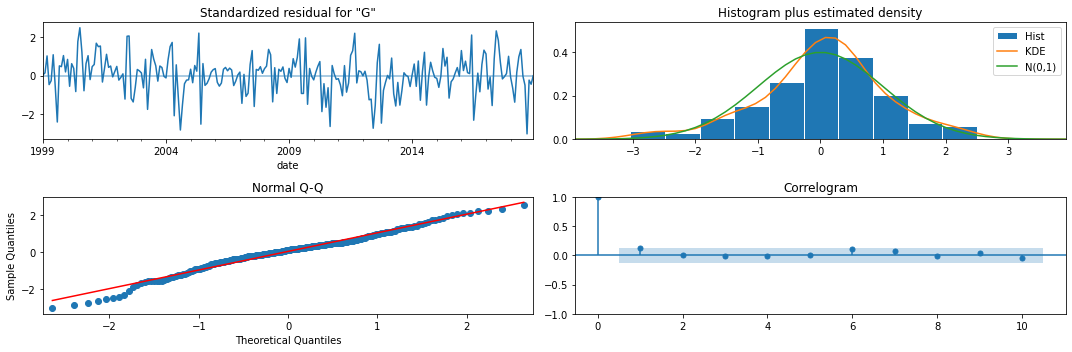

In [88]:
plt.figure(figsize=(20, 10))
model_fit.plot_diagnostics()
plt.tight_layout()
plt.show()

From the diagnostic plots of the fine-tuned SARIMA model, we see that:
- The residual plot seem to fluctuate around a mean of zero, and have a uniform variance. 
- The density plot seems fairly normal, it is a bit off on the left.
- The QQ plot reflect the same problem we see in the density plot.
- The ACF plot shows the residual errors are not autocorrelated. 

We will predict the monthly GHI by using this model for our app.

In [82]:
start = len(train)
end = len(train) + len(test)*2 - 1
pred_future = model_fit.predict(start = start, end=end, type='levels')
pred_future[-12:]

2022-01-01     34.201378
2022-02-01     55.429796
2022-03-01    103.493990
2022-04-01    142.558072
2022-05-01    171.868187
2022-06-01    178.741251
2022-07-01    200.368620
2022-08-01    162.221975
2022-09-01    115.813344
2022-10-01     70.452364
2022-11-01     39.280062
2022-12-01     27.203013
Freq: MS, Name: predicted_mean, dtype: float64

We will save the result so that we can use this for our app.

In [80]:
np.round(pred_future[-12:], decimals=2).to_csv('app_energy.csv')

Let's plot to the future.

In [90]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['GHI'], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test['GHI'], mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=pred_future.index, y=pred_future, mode='lines', name="Predictions"))
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="GHI (kWh/m^2)", 
    xaxis_title="Date",
    title='Monthly GHI in Calgary'
)
fig.show()

We will carry on to Final project-2 Power prediction modeling and evaluation with regression modeling on power estimation.

# Conclusion

In this notebook, we fit the data into the traditional time series model and Facebook prophet model. We found our best performance model is the SARIMA model with order=(0, 0, 0), seasonal=(2, 1, 2, 12), we will move ahead to regression modeling for power estimation.